Plot deep learning feature based image clusters

In [39]:
from pyspark import SparkContext
from pyspark import SparkConf
# from pyspark.mllib.feature import HashingTF, IDF
# from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import KMeans, KMeansModel
from StringIO import StringIO
from PIL import Image
import numpy as np
# import csv
import os, tempfile
import boto
import datetime

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# AWS S3 credentials:

AWS_KEY = ""
AWS_SECRET = ""
sc._jsc.hadoopConfiguration().set("fs.s3n.awsAccessKeyId", AWS_KEY)
sc._jsc.hadoopConfiguration().set("fs.s3n.awsSecretAccessKey", AWS_SECRET)

In [42]:
label_path = 's3n://amlyelp/subset/pic_label_subbybus_train.csv'

In [44]:
# read photo_label map table
photo_label_map = sc.textFile(label_path)
first_line = photo_label_map.take(1)[0]
photo_label_map = photo_label_map.filter(lambda x: x!= first_line).map(lambda x: x.split(','))
photo_label_map = photo_label_map.map(lambda x: (x[0], x[2:]))

In [48]:
# load deep learning feature based photo clusters
cluster_path = 's3n://amlyelp/subset/image_cluster_result/image_cluster_deep_feature_15c_2016-03-02_01_00_38_432723/'

In [49]:
# turn txt into key value pairs
photo_cluster_map = sc.textFile(cluster_path)
photo_cluster_map = photo_cluster_map.map(lambda x: x.replace("(u",'').replace("'",'').replace(')','').split(','))
photo_cluster_map = photo_cluster_map.map(lambda x: (x[0].strip(), x[1].strip()))

In [53]:
# print photo_cluster_map.count()
# print photo_label_map.count()

In [54]:
# join the two tables
photo_map_combined = photo_cluster_map.leftOuterJoin(photo_label_map)

In [56]:
# extract photo cluster-label map
cluster_label = photo_map_combined.map(lambda x: x[1])

In [58]:
from collections import Counter

In [59]:
label_cluster_bar = {}
for i in range(9):
    label_cluster_bar[str(i)] = dict(cluster_label.map(lambda x: (x[1][i], x[0])).groupByKey()\
                                                  .mapValues(lambda x: Counter(x)).collect())

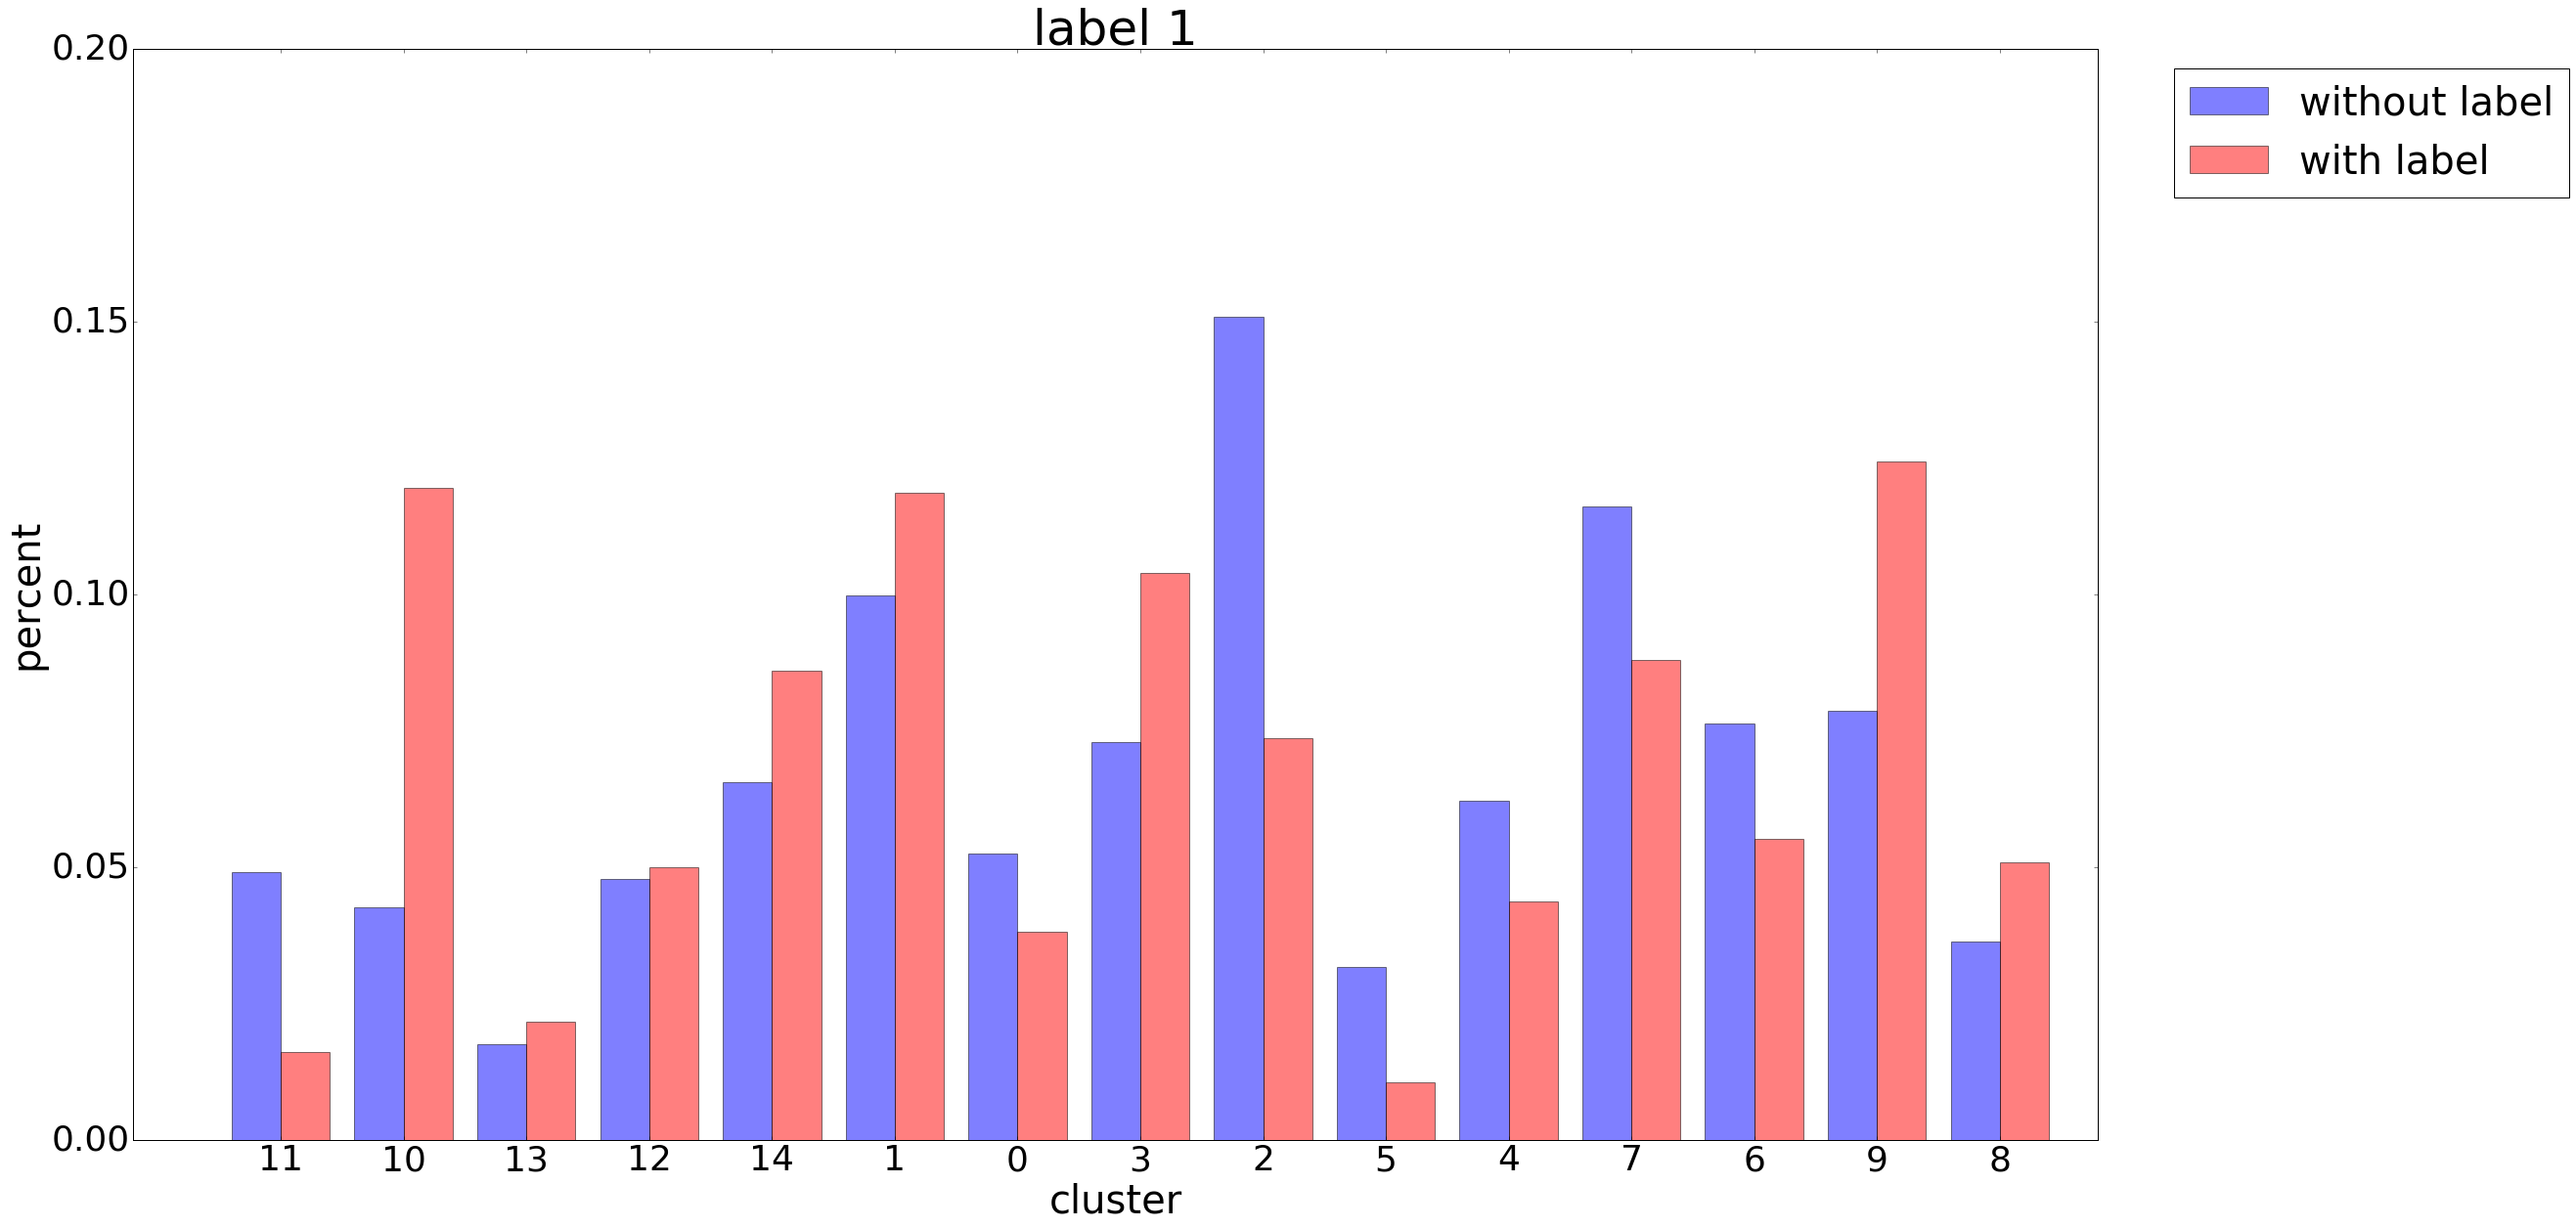

In [70]:
# plot percentage of photos with and without label under each cluster
label_id = '1'
# plt.bar(range(len(D)), D.values(), align='center')
# plt.xticks(range(len(D)), D.keys())

width=0.4
keys = list(set(label_cluster_bar[label_id]['0'].keys()) | set(label_cluster_bar[label_id]['1'].keys()))

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(40,20))

bar_0 = [label_cluster_bar[label_id]['0'].get(key,0) for key in keys]
bar_0 = np.array(bar_0)/float(sum(bar_0))

bar_1 = [label_cluster_bar[label_id]['1'].get(key,0) for key in keys]
bar_1 = np.array(bar_1)/float(sum(bar_1))

ax1.bar(np.arange(len(keys)), bar_0, width=width, align='center', color = 'b',alpha=0.5,label='without label')
ax1.bar(np.arange(len(keys))+width, bar_1, width=width, align='center', color = 'r',alpha=0.5,label='with label')
ax1.set_xticks(np.arange(len(keys))+width/2)
ax1.set_xticklabels(keys, rotation=0, ha='center')
# ax1.set_xticks(keys)

ax1.set_xlabel('cluster', fontsize = 40) 
ax1.set_ylabel('percent', fontsize = 40) 
ax1.set_title('label %s' % label_id, fontsize =50)

ax1.set_xlim((-1, len(keys)))
ax1.set_ylim((0, 0.2))

ax1.legend(loc='upper right', fontsize=40, bbox_to_anchor=(1.25, 1))
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])

for label in ax1.get_yticklabels()+ax1.get_xticklabels():
    label.set_fontsize(36)

plt.show()

In [63]:
from boto.s3.connection import S3Connection
from boto.s3.key import Key

AWS_KEY = ""
AWS_SECRET = ""

conn = S3Connection(AWS_KEY, AWS_SECRET, host='s3.amazonaws.com')
pb = conn.get_bucket('amlyelp')

k = Key(pb)

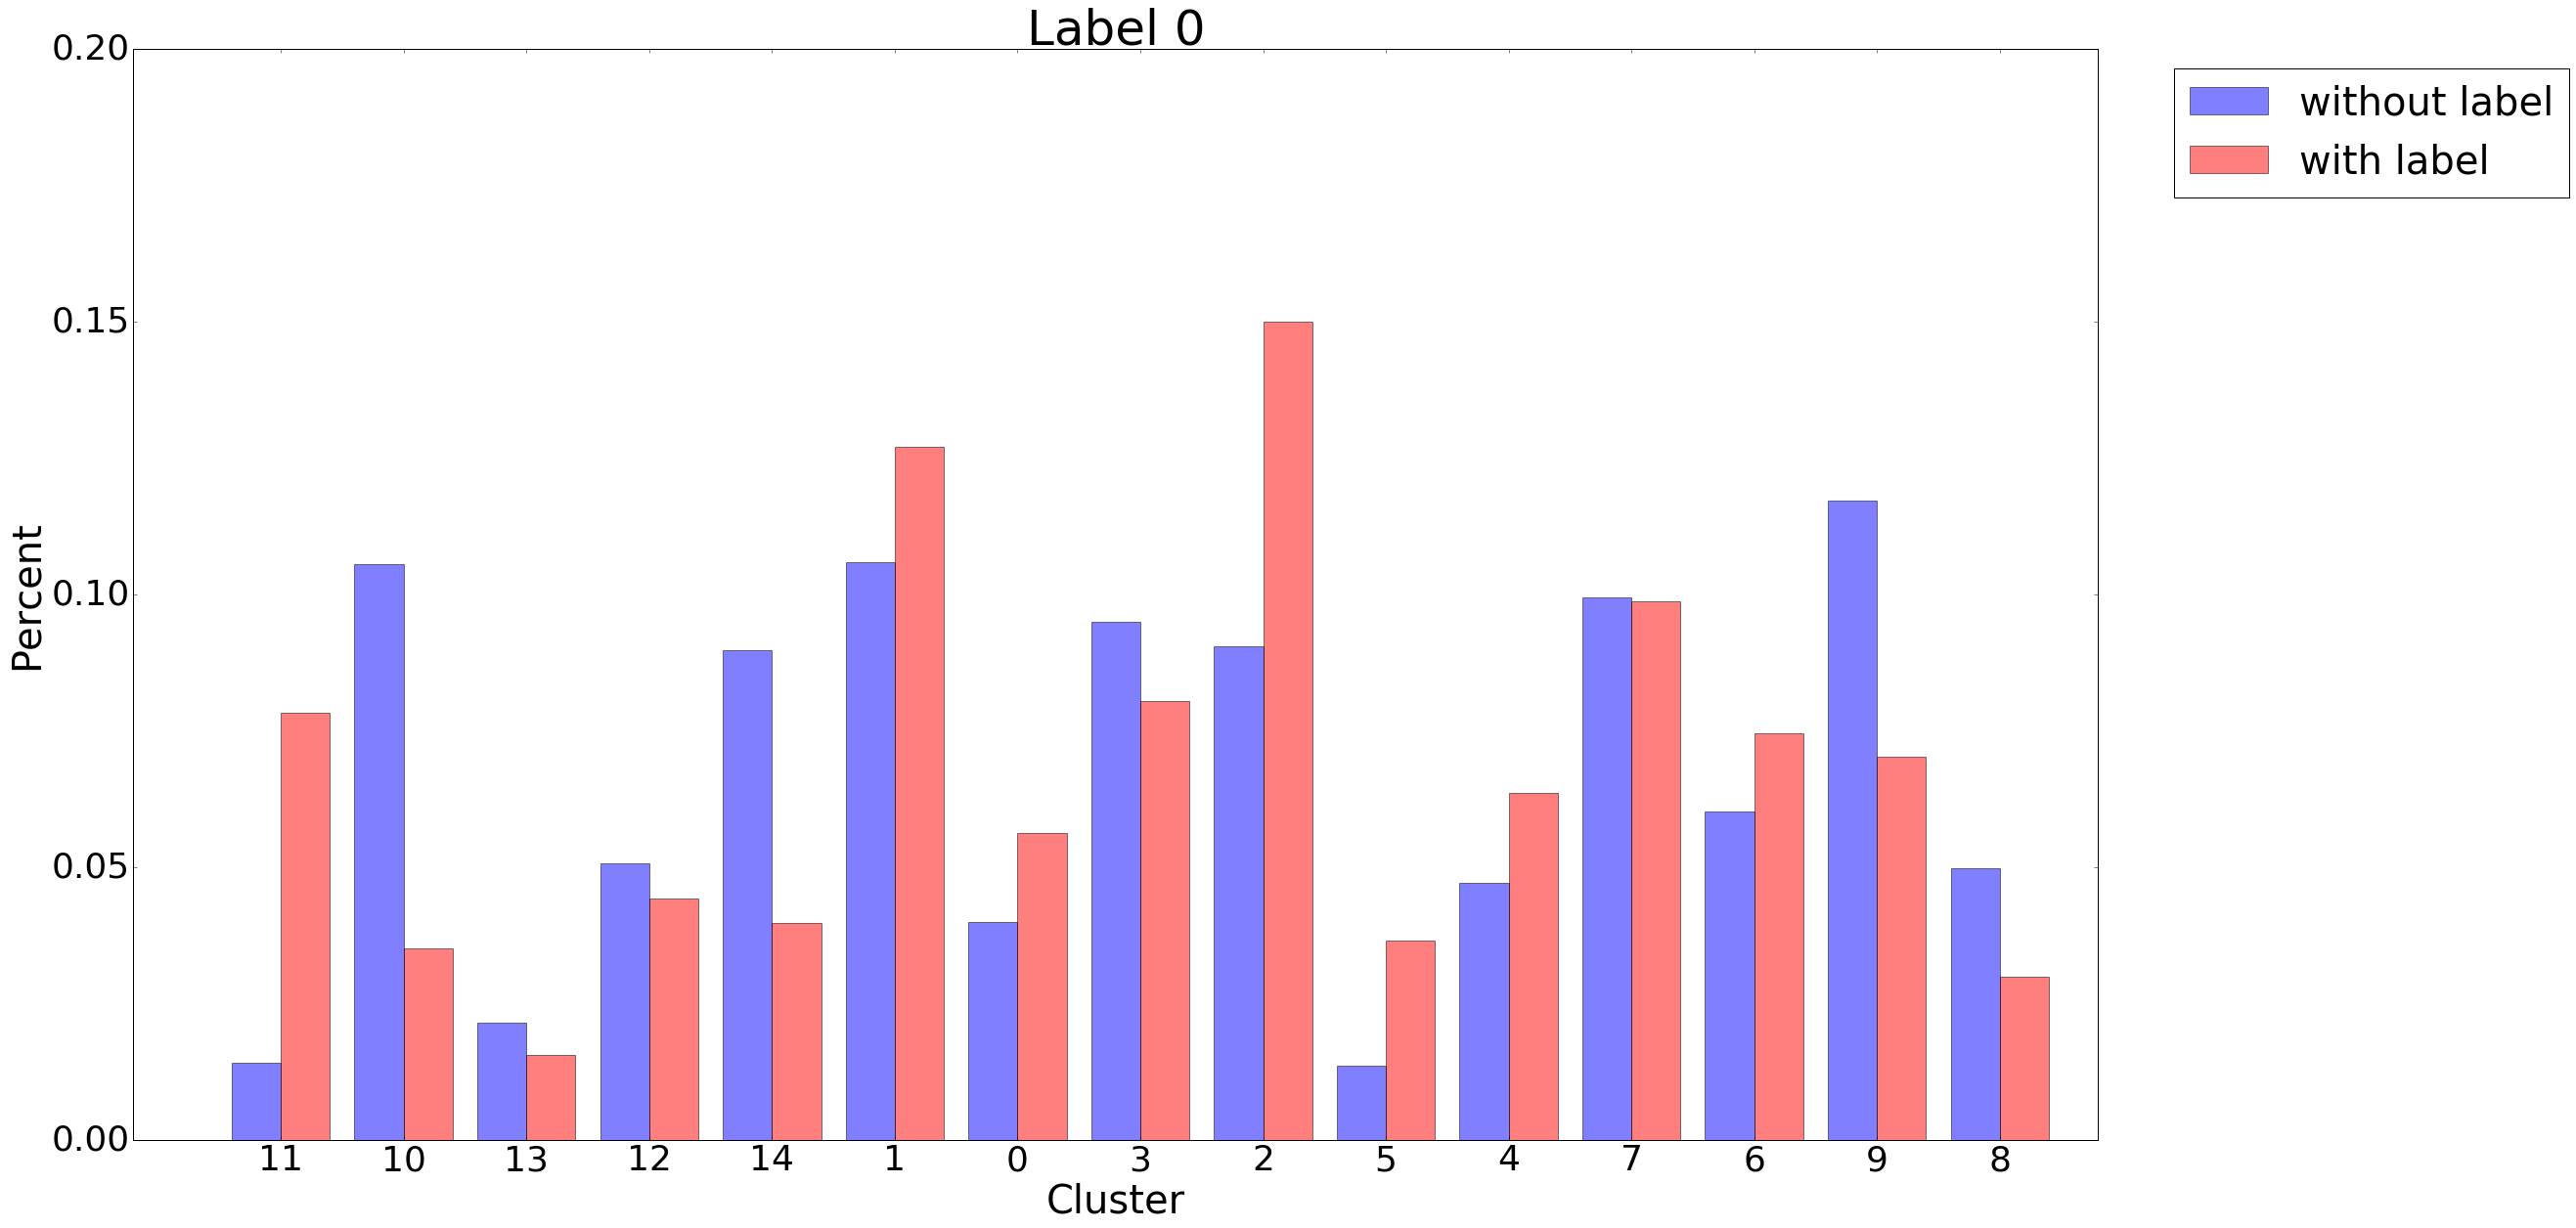

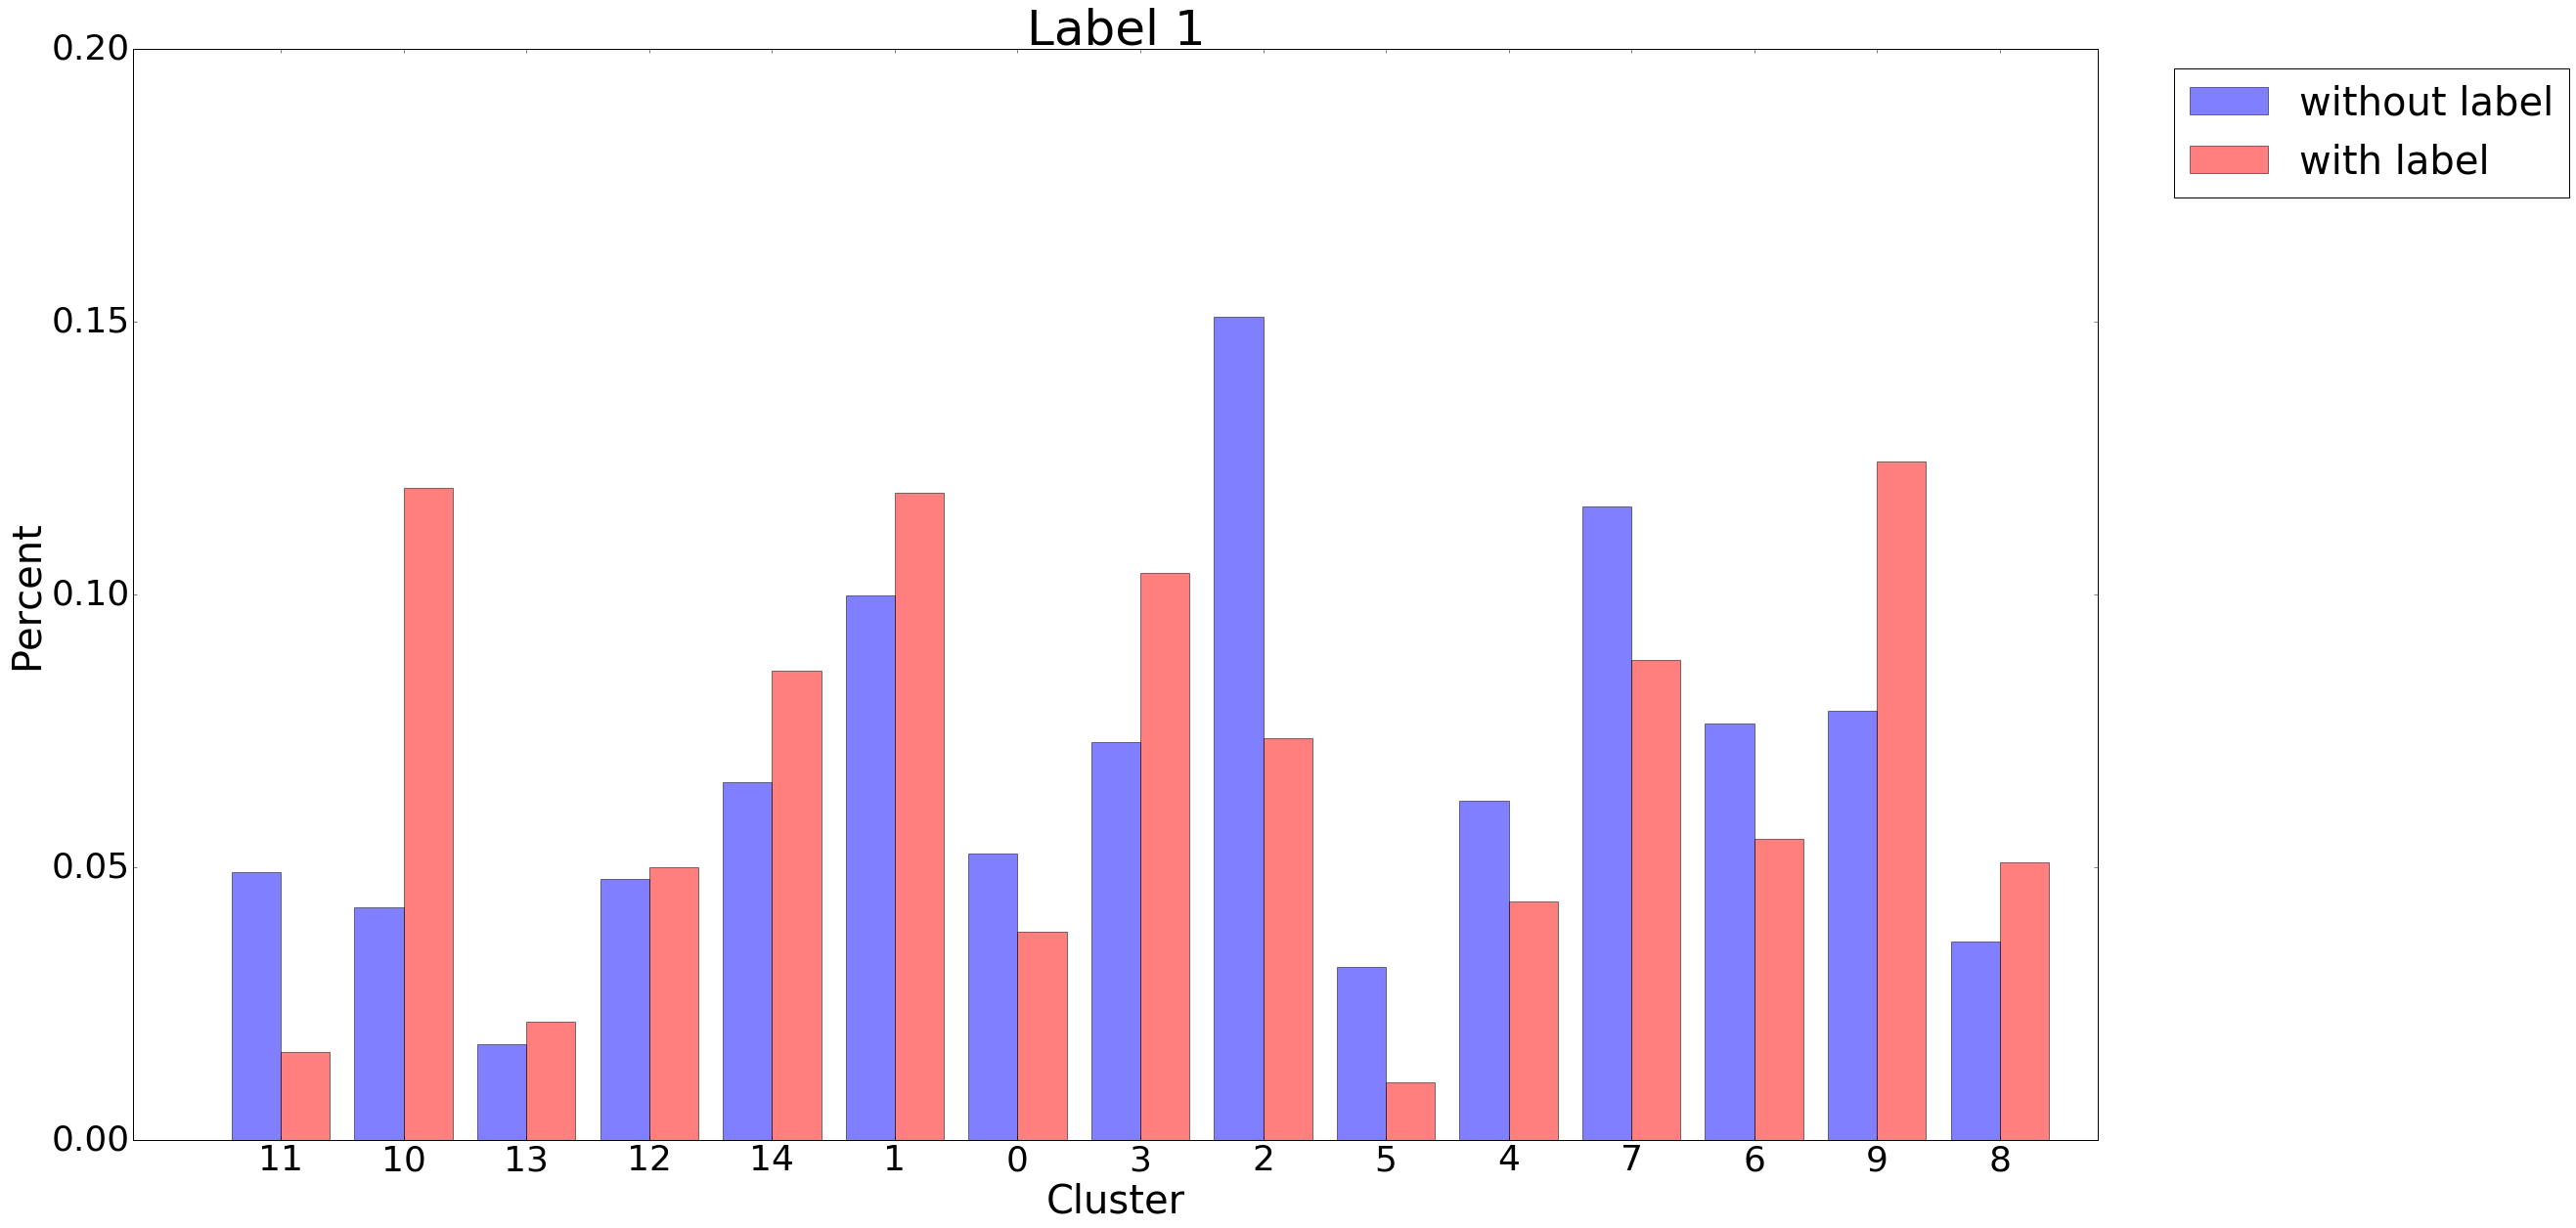

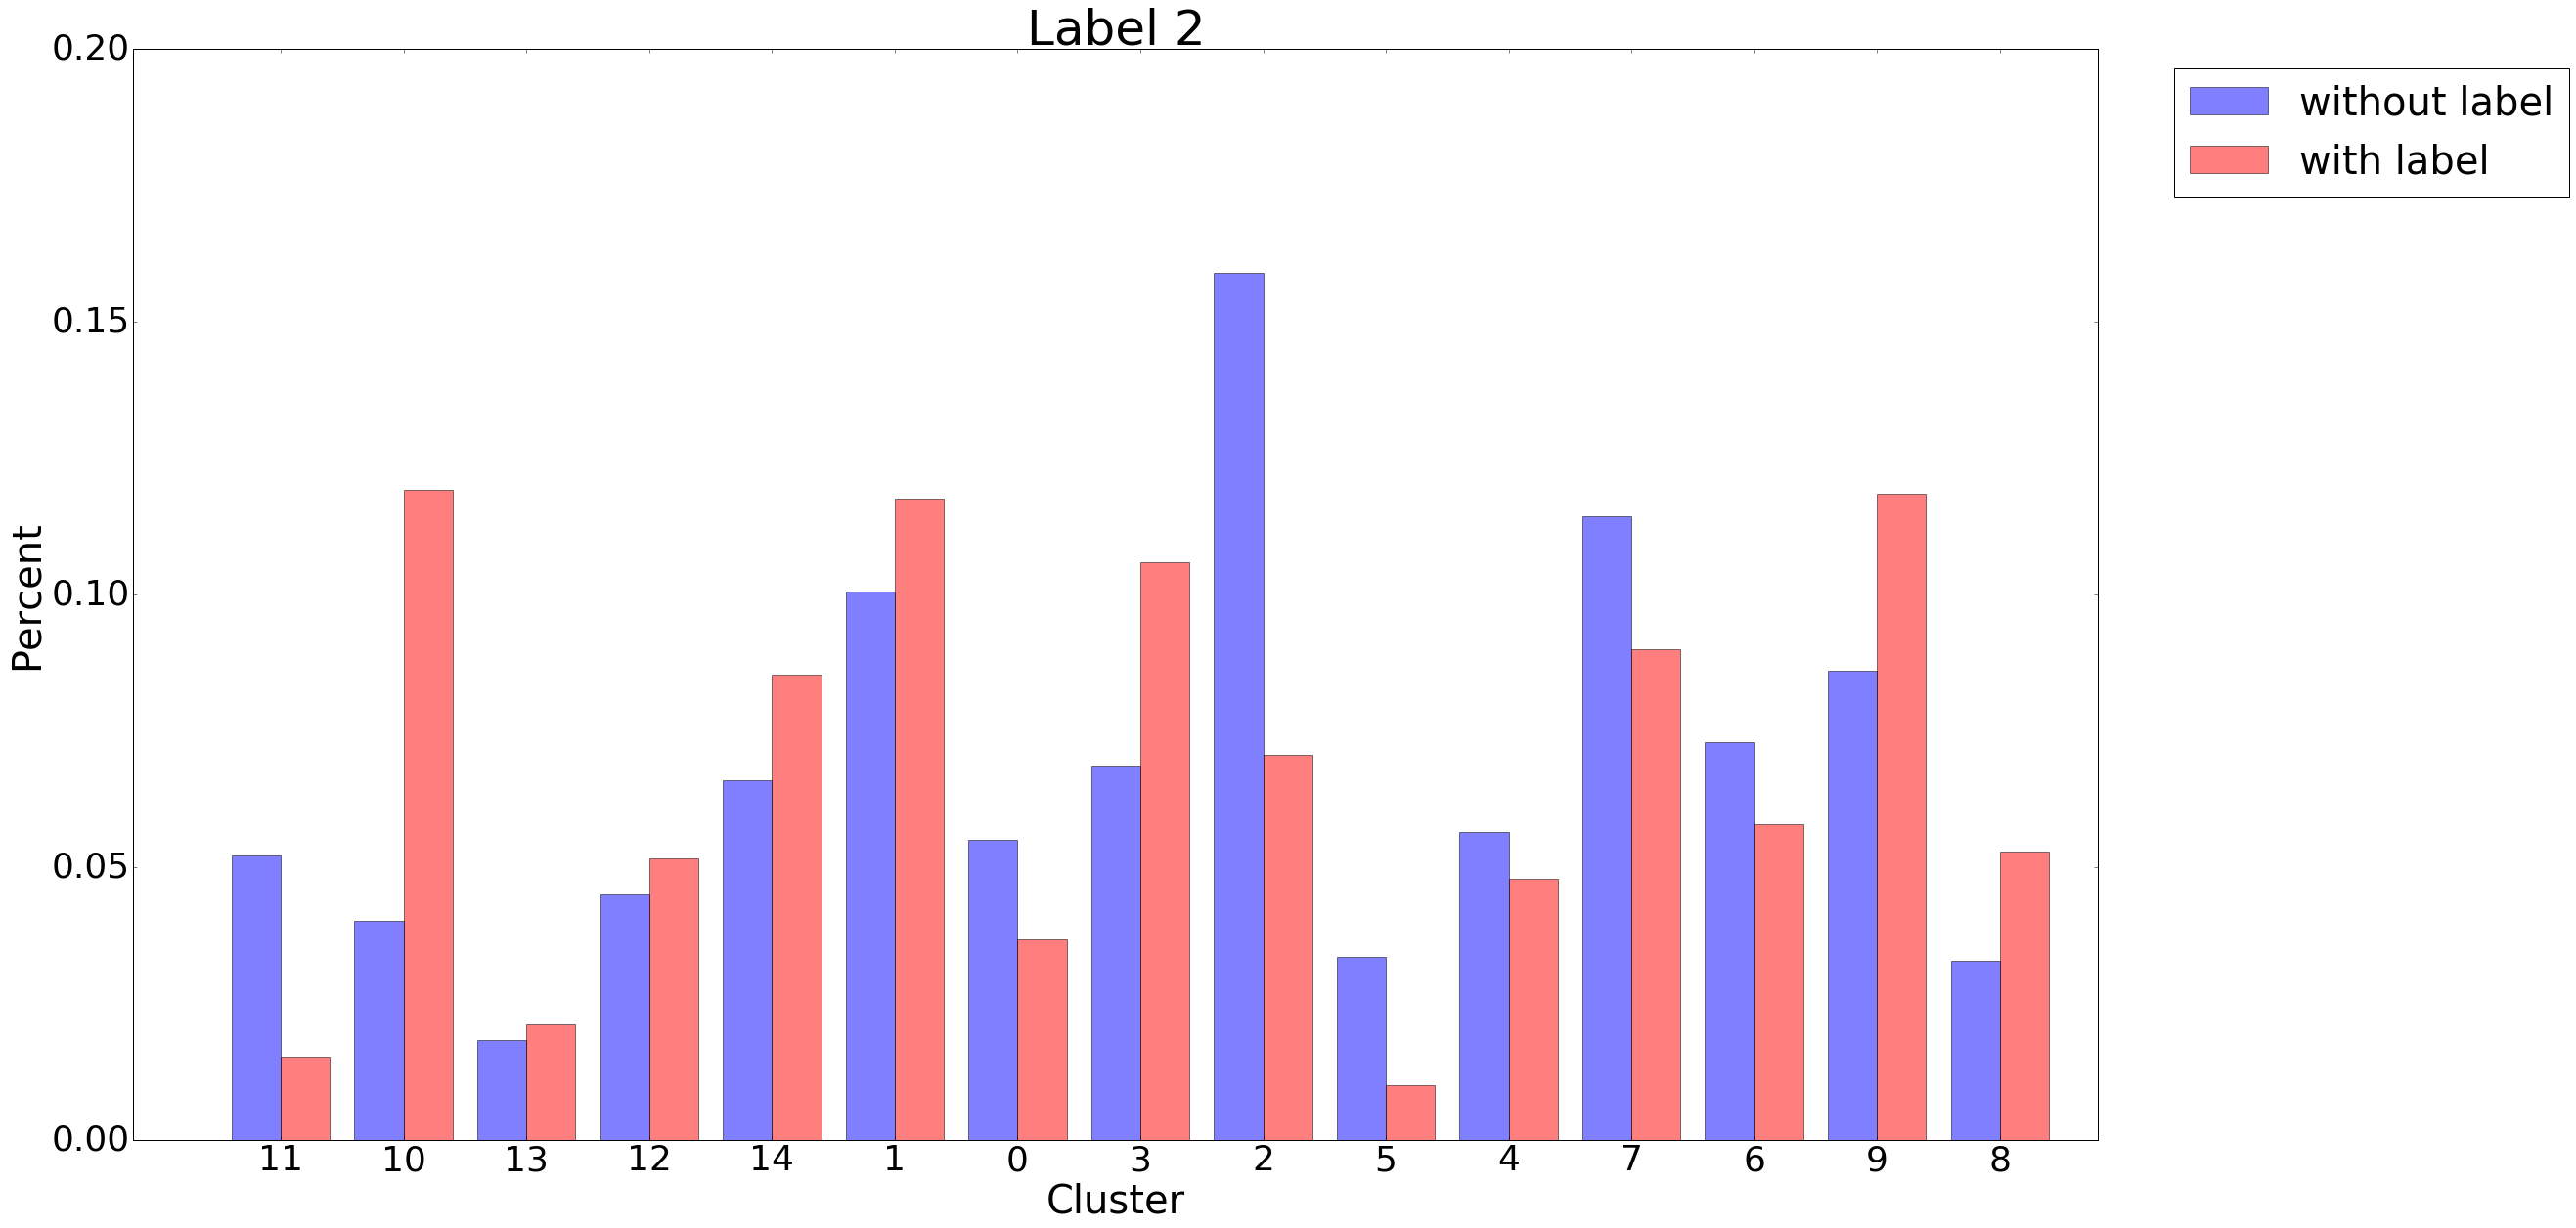

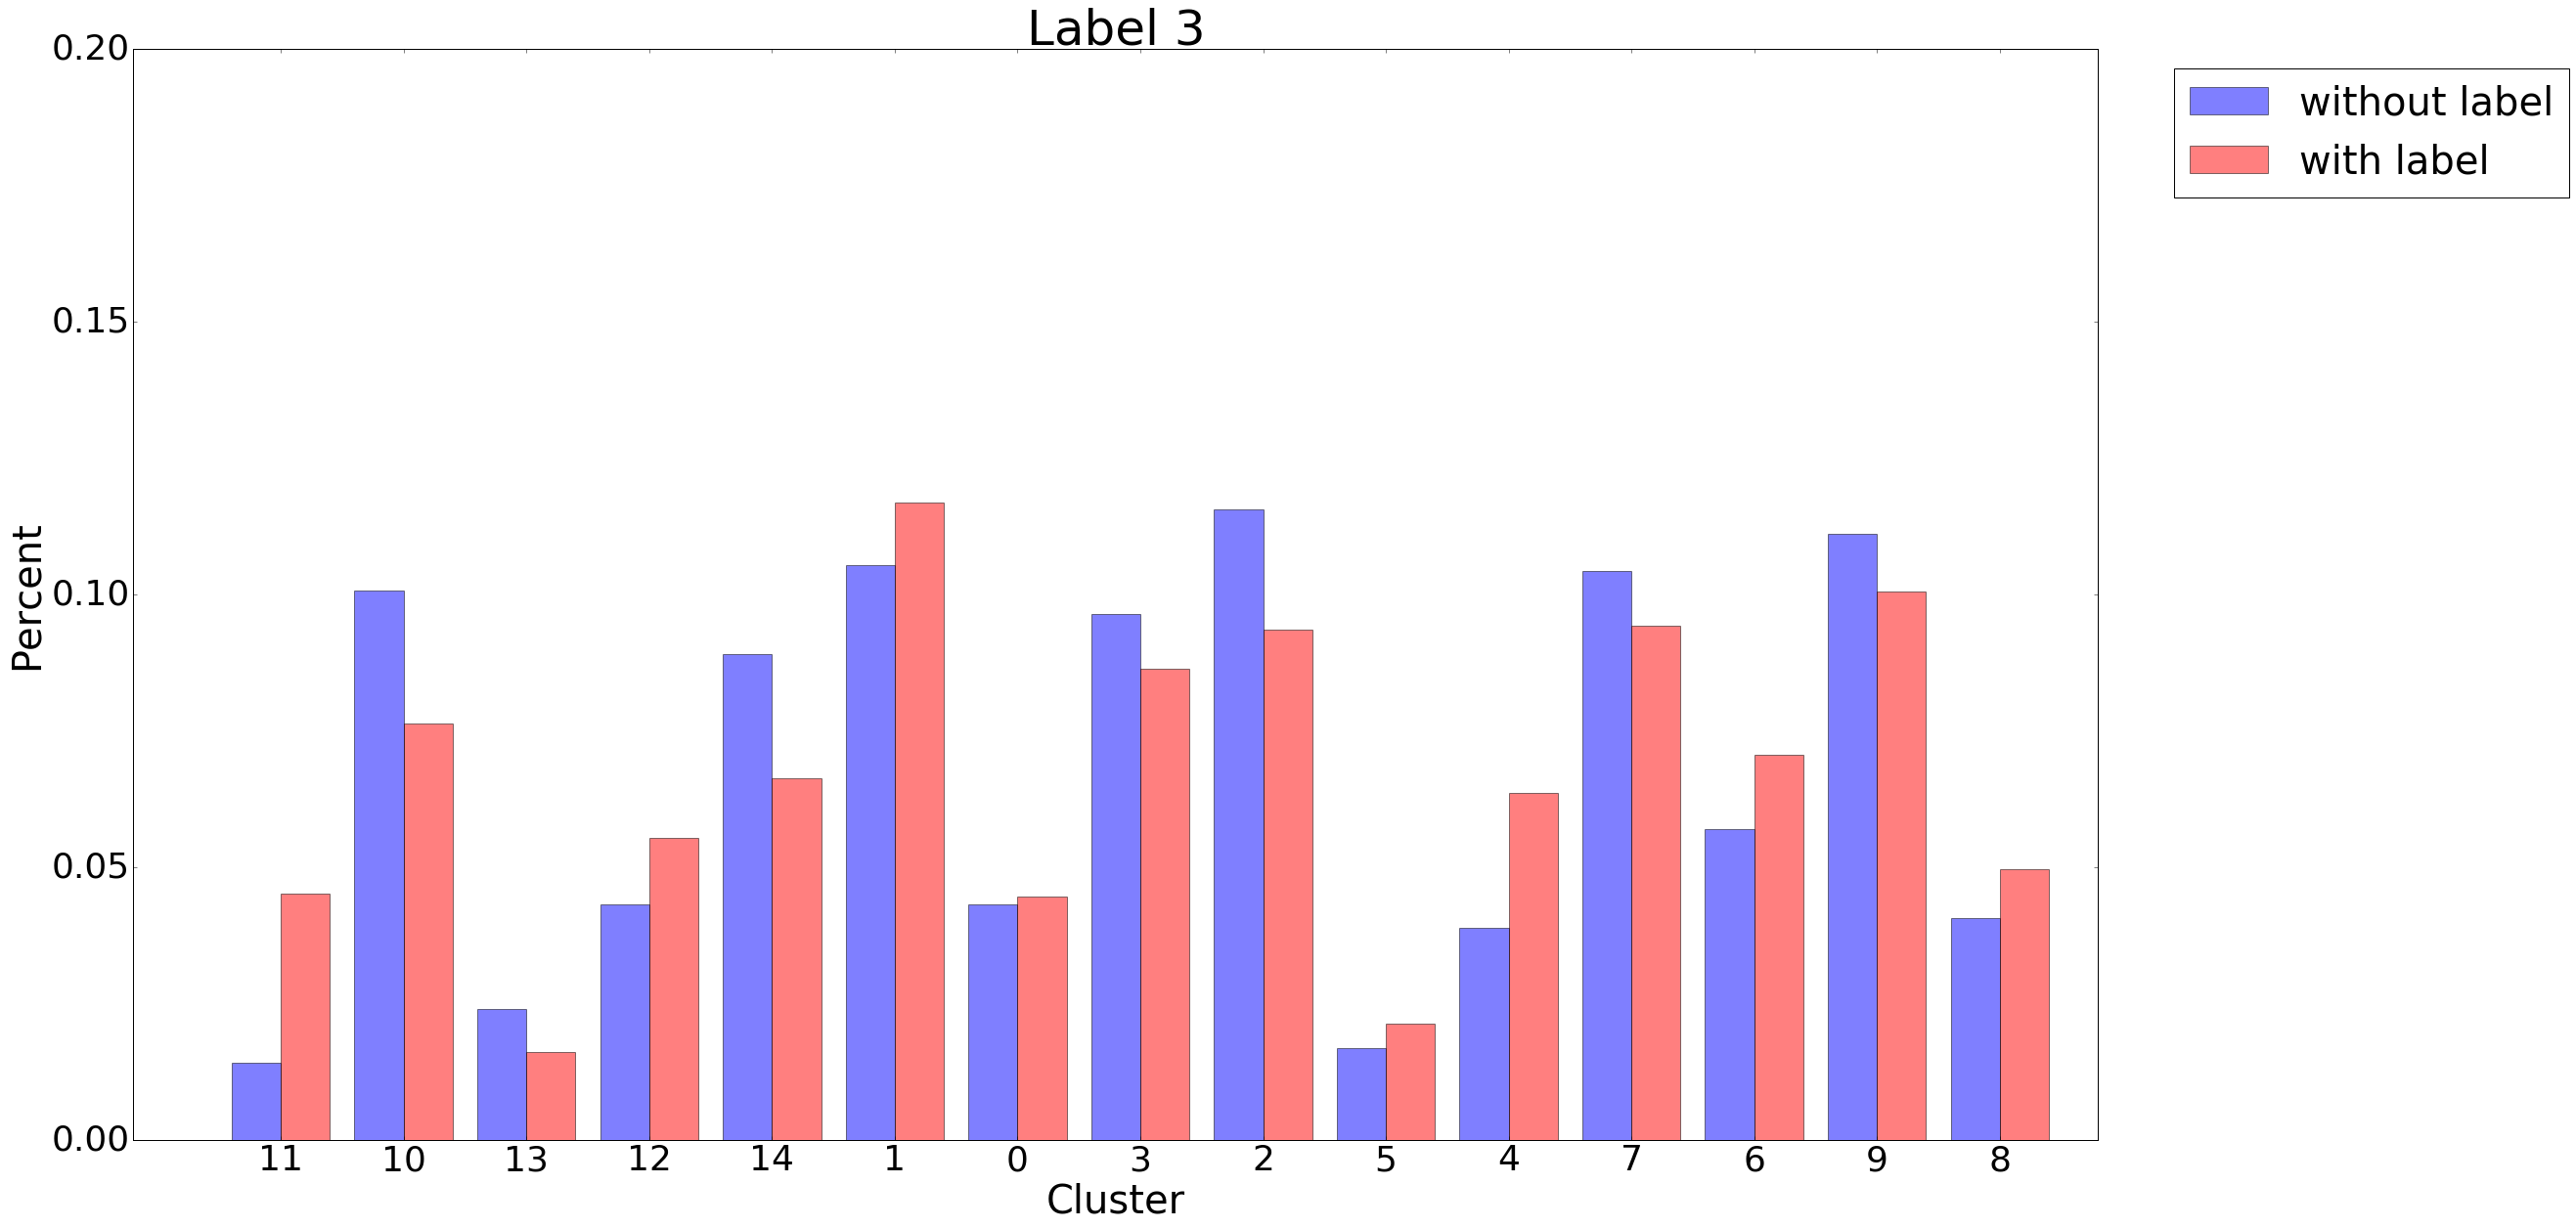

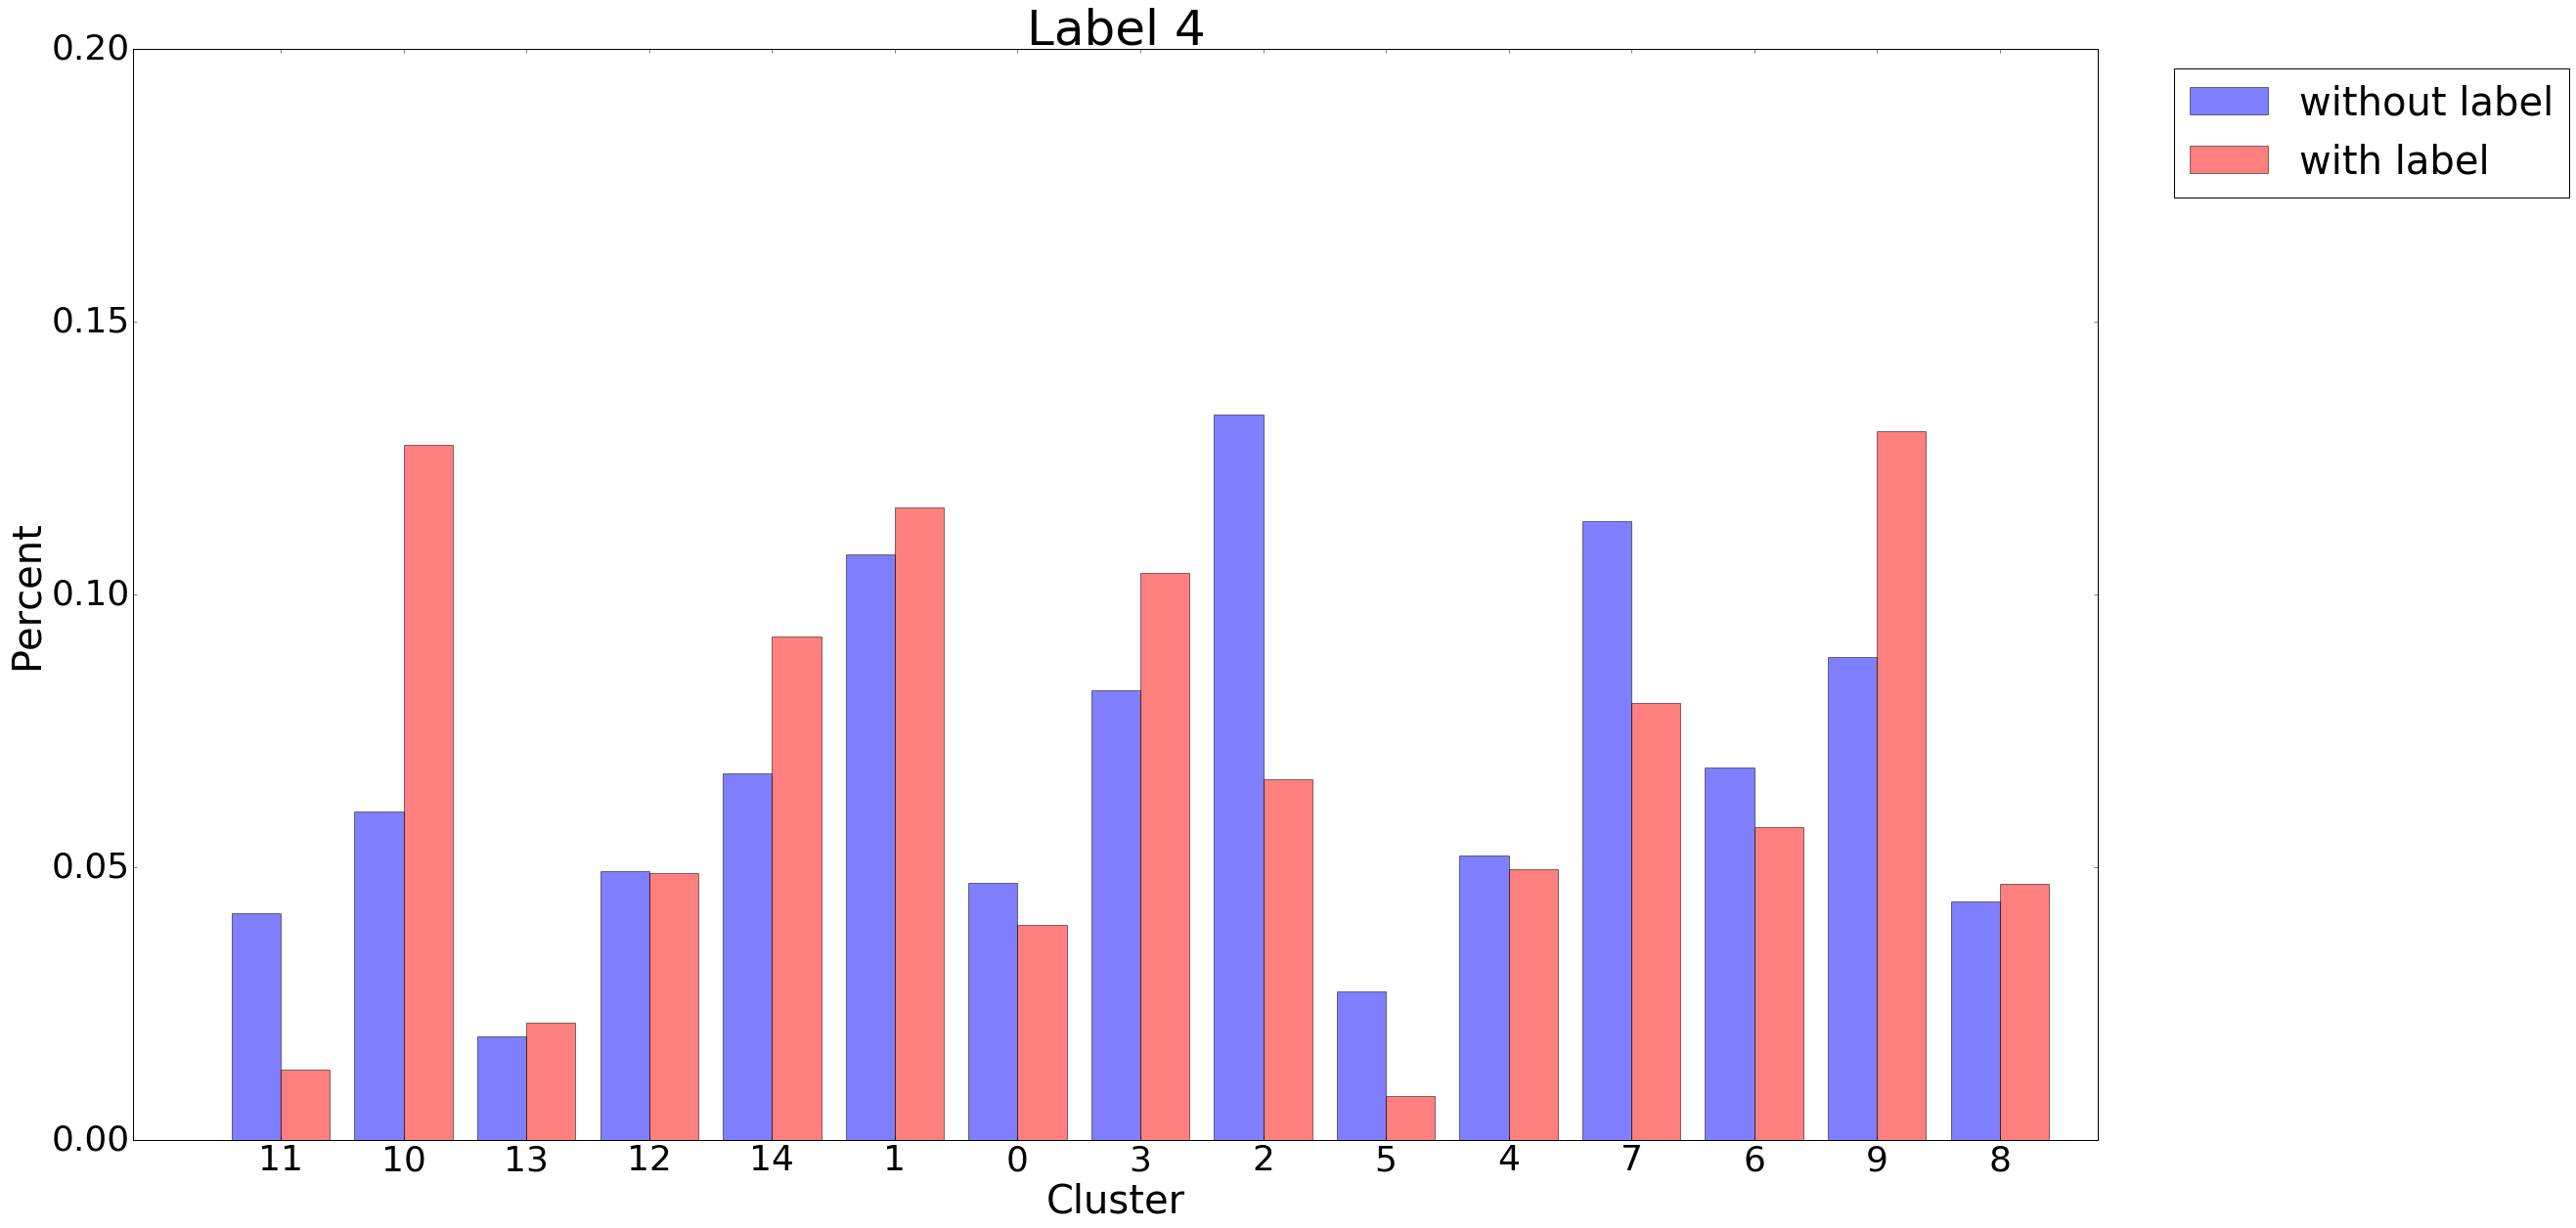

In [ ]:
# save cluster plots to S3
for label_id in np.arange(9).astype(str):
    keys = list(set(label_cluster_bar[label_id]['0'].keys()) | set(label_cluster_bar[label_id]['1'].keys()))
    width=0.4
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(40,20))

    bar_0 = [label_cluster_bar[label_id]['0'].get(key,0) for key in keys]
    bar_0 = np.array(bar_0)/float(sum(bar_0))

    bar_1 = [label_cluster_bar[label_id]['1'].get(key,0) for key in keys]
    bar_1 = np.array(bar_1)/float(sum(bar_1))

    ax1.bar(np.arange(len(keys)), bar_0, width=width, align='center', color = 'b',alpha=0.5,label='without label')
    ax1.bar(np.arange(len(keys))+width, bar_1, width=width, align='center', color = 'r',alpha=0.5,label='with label')
    ax1.set_xticks(np.arange(len(keys))+width/2)
    ax1.set_xticklabels(keys, rotation=0, ha='center')
    # ax1.set_xticks(keys)

    ax1.set_xlabel('cluster'.title(), fontsize = 40) 
    ax1.set_ylabel('percent'.title(), fontsize = 40) 
    ax1.set_title(('label %s' % label_id).title(), fontsize =50)

    ax1.set_xlim((-1, len(keys)))
    ax1.set_ylim((0, 0.2))

    ax1.legend(loc='upper right', fontsize=40, bbox_to_anchor=(1.25, 1))
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])

    for label in ax1.get_yticklabels()+ax1.get_xticklabels():
        label.set_fontsize(36)


    s3_file = "15c_label_%s.png" % label_id
    s3_path = "subset/image_cluster_result/deep_feature_plot"
    file_name_to_use_in_s3 = "%s/%s"%(s3_path, s3_file)
    k.name = file_name_to_use_in_s3

    with tempfile.TemporaryFile(suffix=".png") as tmpfile:
        fig.savefig(tmpfile, format="png") # File position is at the end of the file.
        tmpfile.seek(0) # Rewind the file. (0: the beginning of the file)
        k.set_contents_from_file(tmpfile)